In this notebook we will go over some simple techniques in topic modeling: ```SVD```, ```NMF``` and ```LDA``` . We will also learn about the concepts of ```perplexity``` and ```topic coherence```.

We will be using scikit-learn's ```20newsgroups``` dataset.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import nltk
import gensim
from sklearn.datasets import fetch_20newsgroups

## Download and survey the data

In [3]:
# obtain the dataset
# for our purposes it will suffice to only looking at the training set
newsgroups = fetch_20newsgroups(subset = 'train')

In [4]:
# list of newsgroups categories
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For demonstration purposes, let us only consider 7 categories of the newgroups. This will allow us to keep the corpora short and therefore our computing times low. 

In [5]:
categories = ['alt.atheism','comp.graphics','misc.forsale','rec.autos','sci.crypt','soc.religion.christian','talk.politics.guns']
remove = ('headers', 'footers', 'quotes')
newsgroups = fetch_20newsgroups(subset = 'train', categories = categories, remove = remove)

In [6]:
# number of documents in our dataset
newsgroups.filenames.shape

(3983,)

In [7]:
# checkout the first three entries in the dataset
# we will seperate each entry by '\n\n=*=*=*=*=*=*=*=*=\n'
print('\n\n=*=*=*=*=*=*=*=*=\n'.join(newsgroups.data[:3]))



Find an encyclopedia. Volume H. Now look up Hitler, Adolf. He had
many more people than just Germans enamoured with him.

P.

=*=*=*=*=*=*=*=*=


I don't know which passage you are refering to, but the passage I have
often seen cited as an example of a mother image of God is Isaiah 49:15
"Can a woman forget her sucking child / that she should have no 
compassion / on the son of her womb? / Even these may forget, / 
yet I will not forget you." 
 
This passage is *not* a mother image of God at all. The mother here
is the image of the best human constancy can show, and it is 
contrasted with the constancy of God. The mother figure here represents
mankind, not God.
-- 
Mark Baker                  | "The task ... is not to cut down jungles, but 
aa888@Freenet.carleton.ca   | to irrigate deserts." -- C. S. Lewis

[Luke 13:34   O Jerusalem, Jerusalem, killing the prophets and stoning those
who are sent to you! How often would I have gathered your children together
as a hen gathers her brood

From the above it is quite clear the the entries correspond to politics, religion and graphics respectively. Let's see if this is correct?

In [8]:
# obtain index of the target labels
newsgroups.target[:3]

array([0, 5, 1])

In [9]:
# obtain the corresponding elements from target_names
np.array(newsgroups.target_names)[newsgroups.target[:3]]

array(['alt.atheism', 'soc.religion.christian', 'comp.graphics'],
      dtype='<U22')

Notice that the first one has be categorized under atheism while we had guessed politics! This shows the intersectionality between atheism and politics!

In [10]:
# number of documents in each category
for ind in range(7):
    target = newsgroups.target_names[ind]
    print('{}: {} '.format(target,(newsgroups.target == ind).astype(int).sum()))

alt.atheism: 480 
comp.graphics: 584 
misc.forsale: 585 
rec.autos: 594 
sci.crypt: 595 
soc.religion.christian: 599 
talk.politics.guns: 546 


## Data Preprocessing

For puposes of topic modeling, we will first preprocess our data. We will therefore reduce all the words to lower case, remove stop words and apply stemming/lemmatization.

In [11]:
from nltk import stem # This contains the PorterStemmer as well as the WordNetLemmatizer of nltk
from nltk.corpus import stopwords

In [12]:
porter = stem.PorterStemmer()

In [13]:
# the preprocessing function will stem all the words and convert them to lowercase
preproc= lambda string: ' '.join(map(lambda word: porter.stem(word), string.lower().split()))

In [14]:
newsgroups.data[0]

'\n\nFind an encyclopedia. Volume H. Now look up Hitler, Adolf. He had\nmany more people than just Germans enamoured with him.\n\nP.'

In [15]:
preproc(newsgroups.data[0])

'find an encyclopedia. volum h. now look up hitler, adolf. he had mani more peopl than just german enamour with him. p.'

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# after stemming the documents, some of the words may no longer be identified as stop-words as their stemmed version 
# will not be in the list of stop words. These words will therefore not be removed from the text
# to cure this, apply stemming to the stop words and add them to the list of stop words
# for e.g. see joeln's reply in this post: 
# https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing
stop_words = set(stopwords.words('english'))
print('no. of stop words before stemming: {}'.format(len(stop_words)))
stemmed_stop_words = set(map(lambda word: preproc(word), stop_words))
stop_words.update(stemmed_stop_words)
print('no. of stop words after stemming: {}'.format(len(stop_words)))

no. of stop words before stemming: 179
no. of stop words after stemming: 201


In [18]:
# create a vectorizer with english stop words and the above preprocessing function
# the vectorizer automatically ignores all punctuations
vectorizer = CountVectorizer(stop_words = stop_words, preprocessor = preproc )

In [19]:
# fit the vectorizer to the data to obtain a bag-of-words matrix
# To test the our preprocessing function, let's just try to fit the vectorizer only on the first document
bow = vectorizer.fit_transform(newsgroups.data[0:1]).todense()
bow.shape

/home/prarit/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(1, 10)

In [20]:
# the individual tokens can be obtained from the get_feature_names() method of the vectorizer
vectorizer.get_feature_names()

['adolf',
 'enamour',
 'encyclopedia',
 'find',
 'german',
 'hitler',
 'look',
 'mani',
 'peopl',
 'volum']

The feature names produced by our vectorizer seem to match with the 1st document in our corpora. The preprocessing function that we created above seems to be working fine. Let's now fit the vectorizer to the entire dataset.

In [21]:
bow = vectorizer.fit_transform(newsgroups.data).todense()
print('shape of document-term matrix is: {}'.format(bow.shape))
# print some of the tokens generated by the vectorizer
# The first few ones seem to be numbers and emails etc. so I chose the indices to correspond to english words
print('Sample of tokens generated: {}'.format(vectorizer.get_feature_names()[7500:7510]))

shape of document-term matrix is: (3983, 38819)
Sample of tokens generated: ['bells', 'belong', 'belonging', 'belongs', 'belorusskaya', 'belov', 'beloved', 'belt', 'belts', 'beltway']


In [22]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(38819,)

## SVD: Singular Value Decomposition

Let us now apply SVD for topic modeling. Also, we will use sklearn's [```randomized_svd``` ](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html) since it is much faster

In [23]:
from sklearn.utils.extmath import randomized_svd

In [24]:
num_topics = 20
U, S, V = randomized_svd(bow, n_components = num_topics)

In [25]:
print('shape of U: {}'.format(U.shape))
print('shape of S: {}'.format(S.shape))
print('shape of V: {}'.format(V.shape))

shape of U: (3983, 20)
shape of S: (20,)
shape of V: (20, 38819)


In [26]:
S[:10]

array([613.60405179, 574.17273772, 362.07868416, 344.71683751,
       299.56507465, 255.67491512, 237.53532097, 212.53588514,
       194.21425178, 180.92764131])

Let us now display the top 10 words in each of the topics

In [27]:
top_k = 10
top_k_word_indices = V.argsort(axis = 1)[:, :-top_k-1:-1]

In [28]:
def show_topic_words(topic_vector, vocab , top_k = 10):
    top_word_indices = topic_vector.argsort()[:-top_k-1:-1]
    words = vocab[top_word_indices]
    weights = topic_vector[top_word_indices]
    # zip the weights and words and make a string our of them
    topic = '+'.join(map(lambda tup: str(tup[0])[:5]+'*'+tup[1] ,zip(weights,words)))
    return topic

In [30]:
# let us view the top 10 topics
for idx, vector in enumerate(V[:10]):
    print('topic: {}'.format(idx+1))
    print(show_topic_words(vector, vocab))

topic: 1
0.873*db+0.217*mov+0.189*bh+0.142*cs+0.140*si+0.090*bit+0.083*byte+0.078*al+0.074*bl+0.074*file
topic: 2
0.378*file+0.239*use+0.204*imag+0.188*jpeg+0.154*edu+0.134*anonym+0.127*pub+0.115*ftp+0.112*mail+0.112*system
topic: 3
0.642*file+0.288*gun+0.139*congress+0.128*firearm+0.124*control+0.119*bill+0.110*state+0.102*mr+0.096*handgun+0.094*rkba
topic: 4
0.495*jpeg+0.339*imag+0.212*gif+0.167*color+0.139*format+0.101*version+0.085*display+0.084*convert+0.081*file+0.081*bit
topic: 5
0.208*edu+0.203*pub+0.136*mail+0.134*ftp+0.099*comput+0.097*data+0.089*internet+0.087*send+0.085*graphic+0.084*file
topic: 6
0.217*00+0.194*edu+0.163*god+0.110*data+0.109*graphic+0.099*128+0.098*3d+0.090*50+0.090*ray+0.085*40
topic: 7
0.660*00+0.245*50+0.211*appears+0.210*40+0.170*10+0.167*art+0.129*25+0.123*20+0.118*1st+0.112*80
topic: 8
0.267*anonym+0.171*post+0.149*edu+0.102*god+0.099*server+0.089*file+0.087*anon+0.083*jpeg+0.080*servic+0.073*mail
topic: 9
0.292*pub+0.232*eff+0.197*god+0.150*jpeg+0.1

From above, we see that topic 1, 2, 4, 5 and 8 seem to correspond to computer science and graphics related subjects. Similarly, topic 3 is clearly related to politics and guns. Topic 6 has a high component of 'god' but other words seem to be cs/graphics related. It is therefore much harder to tell what exactly does it represent. topic 7 mostly seems to be made up of number wich don't seem to tell us much either. topic 9 seems to an admixture of religion, atheism, politics and cs/graphics. Topic 10 can be clearly associated with atheism and religion. 

Thus we see that while some of the topics are very interpretable but still others are hard to make sense of. We also notice that our topics are largely dominated by words related to cs/graphics. I wonder why?

Let's see if using a tf-idf vectorizer instead of count vectorizer makes a difference and gives a better selection of topics

## SVD with tf-idf

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
vectorizer = TfidfVectorizer(stop_words = stop_words, preprocessor = preproc)

In [33]:
tfidf_mat = vectorizer.fit_transform(newsgroups.data).todense()
tfidf_mat.shape

/home/prarit/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(3983, 38819)

In [34]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(38819,)

In [35]:
num_topics = 20
U,S, V = randomized_svd(tfidf_mat, n_components = num_topics)

In [36]:
print('shape of U: {}'.format(U.shape))
print('shape of S: {}'.format(S.shape))
print('shape of V: {}'.format(V.shape))

shape of U: (3983, 20)
shape of S: (20,)
shape of V: (20, 38819)


In [37]:
S[:10]

array([8.51841333, 4.92967855, 4.37497754, 3.83602063, 3.51430331,
       3.3639679 , 3.04066331, 3.01200984, 2.9947416 , 2.94790133])

In [38]:
# let us view the top 10 topics
for idx, vector in enumerate(V[:10]):
    print('topic: {}'.format(idx+1))
    print(show_topic_words(vector, vocab))

topic: 1
0.188*would+0.163*one+0.157*god+0.146*use+0.126*peopl+0.122*key+0.121*like+0.119*think+0.118*know+0.112*get
topic: 2
0.388*key+0.229*chip+0.206*encrypt+0.143*clipper+0.139*use+0.127*escrow+0.109*system+0.109*secur+0.104*bit+0.092*algorithm
topic: 3
0.330*key+0.199*god+0.184*chip+0.175*encrypt+0.124*clipper+0.116*escrow+0.088*secur+0.083*law+0.083*govern+0.076*believ
topic: 4
0.341*gun+0.178*car+0.116*right+0.101*peopl+0.099*crime+0.098*weapon+0.090*would+0.086*state+0.085*govern+0.085*law
topic: 5
0.337*00+0.289*car+0.178*god+0.143*key+0.130*price+0.115*sale+0.113*new+0.108*offer+0.104*drive+0.087*chip
topic: 6
0.352*00+0.238*gun+0.143*law+0.100*sale+0.084*control+0.083*offer+0.081*govern+0.081*weapon+0.078*crime+0.078*includ
topic: 7
0.240*00+0.200*could+0.180*ico+0.178*tek+0.176*bobbe+0.174*beauchain+0.174*sank+0.174*bronx+0.173*manhattan+0.168*stay
topic: 8
0.296*gun+0.253*god+0.174*key+0.146*file+0.146*bit+0.141*ico+0.139*tek+0.138*bobbe+0.137*beauchain+0.137*sank
topic: 9

Using a vectorizer based on tfidf seems to a little better. Previously, using the simple vectorizer, we got a topic (topic 7 in the results from previous section) which was largely based on numbers and hence did not make much sense. But upon using tfidf, we do not get such a topic in our list of top 10 topics. Also the topics no longer seem to be dominated by cs/graphics related words.

## SVD + Tf-Idf + bigrams

Let us see how things change if we also use bigrams in our vectorizer. 

Let us also, explicitly tell the vectorizer to ignore all number. We can do this by passing an appropriate regex as a token_patten to the vectorizer. The regex to use will be ```r'[a-z]{2,}'```. This will pick all words which are composed of two or more english alphabets.

In [76]:
regex = r'[a-z]{2,}'
vectorizer = TfidfVectorizer(stop_words = stop_words, preprocessor = preproc, 
                             ngram_range = (1,2), token_pattern = regex)

In [77]:
tfidf_mat = vectorizer.fit_transform(newsgroups.data).todense()
tfidf_mat.shape

/home/prarit/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(3983, 323956)

In [78]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(323956,)

In [79]:
num_topics = 20
U, S, V = randomized_svd(tfidf_mat, n_components = num_topics)

In [80]:
print('shape of U: {}'.format(U.shape))
print('shape of S: {}'.format(S.shape))
print('shape of V: {}'.format(V.shape))

shape of U: (3983, 20)
shape of S: (20,)
shape of V: (20, 323956)


In [81]:
S[:10]

array([5.42871277, 3.40051386, 2.96654507, 2.66881381, 2.60402419,
       2.39154452, 2.31469002, 2.20558674, 2.1026558 , 2.04998648])

In [82]:
# let us view the top 10 topics
for idx, vector in enumerate(V[:10]):
    print('topic: {}'.format(idx+1))
    print(show_topic_words(vector, vocab))

topic: 1
0.173*would+0.155*one+0.155*god+0.149*use+0.138*key+0.117*peopl+0.112*like+0.109*know+0.107*think+0.103*get
topic: 2
0.402*key+0.232*chip+0.228*encrypt+0.141*clipper+0.133*escrow+0.117*use+0.116*secur+0.114*bit+0.094*system+0.091*clipper chip
topic: 3
0.163*car+0.124*sale+0.118*offer+0.110*pleas+0.109*drive+0.106*price+0.101*mail+0.096*email+0.096*file+0.091*edu
topic: 4
0.179*ico+0.179*ico tek+0.179*vice ico+0.178*tek com+0.177*tek+0.176*bobbe vice+0.176*bobbe+0.175*blew bronx+0.175*com said+0.175*bob beauchain
topic: 5
0.325*gun+0.141*car+0.111*right+0.097*weapon+0.097*crime+0.094*law+0.090*state+0.088*govern+0.088*would+0.086*peopl
topic: 6
0.264*file+0.166*imag+0.121*program+0.112*format+0.110*ftp+0.095*gun+0.087*graphic+0.080*gif+0.076*data+0.072*code
topic: 7
0.165*law+0.129*offer+0.116*sale+0.114*govern+0.111*encrypt+0.109*god+0.098*technolog+0.094*new+0.087*gun+0.086*protect
topic: 8
0.341*car+0.129*encrypt+0.103*technolog+0.089*clipper+0.081*new+0.079*govern+0.077*pri

Notice that most of the topics are still composed of unigrams, though topic 4 seems to be composed of bigrams. However, just by reading it, it hard to tell what topic 4 corresponds to . Thus, at least for the current dataset, bigrams don't seem to help much. 

## LDA: Latent Dirichlet Allocation

Let us now see how things change with [```Latent Dirichlet Allocation```](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

[Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) has been beautifully summarized/explained in [this](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) blog by Edwin Chen.

Paraphrasing Edwin Chen:

```LDA``` assumes that the documents in our corpora have been generated in the following manner:
   
1. The document d_i had a probability P(t_k | d_i) to corresponds to topic t_k

2. The word w has probability p(w | t_k) to be emitted when the document's topic is t_k
 
3. The r-th position in the document we sample a topic according to its probability p(t_k | d_i) and then sample a word w_r according to its probability to be emitted by the sampled topic i.e. p(w_r | t_k)

Note that LDA's model of word generation is not a language model in that it does not take into account the previous sequence of words when generating the current word. 

Having understood the assumptions that LDA makes about the documents in our corpora, we can now use it to invert the process for topic modeling. The idea is as follows:

1. Decide on the number of topics to model. Let's say this number is K

2. To each word in the corpora, assign one of the K topics. Note that here multiple occurances of the same word are to be treated seperately. Thus the same word can and will be assigned different topics at different instances of its occurance.

3. Step 2 inherently gives us an initial value for P(t_k | d_i) and p(w_r | t_k) for all the words, topics and documents :
    
    p(t_k | d_i) = $\frac{\text{no. of words in d_i with topic t_k}}{\text{total number of words in d_i}}$
    
    p(w_r | t_k) = $\frac{\text{no. of times w_r occurs in the entire corpora with topic t_k}}{\text{total number of words from the entire corpora in t_k }}$

4. Having established an initial probability distribution, which random and hence bound ot be incorrect, we now recurssively correct it. The idea is to iterate over each word in each document and reassign a new topic to it in accordance with the current estimate of the probability distributions. Reiterating over this a large number of times is them expected to asymptote to the correct distibution. 
   
   - The word w_r in a given document d_i is reassigned a topic t_k by sampling t_k with a probability: p(w_r | t_k) * p(t_k | d_i) . 
   
   - Note that the probability distributions will change each time a word is assigned a new topic


Having understood the key ideas behind LDA, let us now apply it to our current dataset

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
regex = r'[a-z]{2,}'
vectorizer = CountVectorizer(stop_words = stop_words, preprocessor = preproc, token_pattern = regex)
bow = vectorizer.fit_transform(newsgroups.data)
bow.shape

/home/prarit/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(3983, 32081)

In [20]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(32081,)

In [105]:
num_topics = 20
LDA = LatentDirichletAllocation(n_components = num_topics)

As mentioned in sklearn's [user guide](https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda) for ```LDA```: When LatentDirichletAllocation is applied on a “document-term” matrix, the matrix will be decomposed into a “topic-term” matrix and a “document-topic” matrix. While “topic-term” matrix is stored as components_ in the model, “document-topic” matrix can be calculated from transform method.

In [106]:
# get the topics for each document
document_topic_mat = LDA.fit_transform(bow)
document_topic_mat.shape

(3983, 20)

In [107]:
# get the words in each topic
topics = LDA.components_
topics.shape

(20, 32081)

In [108]:
# display the words in each topic
for idx, vector in enumerate(topics[:10]):
    print('topic: {}'.format(idx+1))
    print(show_topic_words(vector, vocab))

topic: 1
194.0*jesu+126.2*one+107.8*jesus+87.36*matthew+77.30*christ+74.88*son+63.40*john+62.49*lord+60.35*say+59.55*name
topic: 2
33.99*use+32.08*get+29.86*san+23.47*like+21.80*newsgroup+21.11*media+19.59*post+17.82*ad+17.75*ca+15.28*mail
topic: 3
78.57*one+63.65*argument+58.26*true+58.04*fallaci+57.45*use+53.23*think+37.38*gener+35.76*premis+35.34*would+35.27*ad
topic: 4
232.1*church+105.1*cathol+104.2*pope+59.86*nist+47.41*gov+43.88*canon+41.29*ncsl+41.04*schism+40.74*bishop+33.44*would
topic: 5
268.8*jpeg+194.4*imag+189.7*color+165.2*gif+141.3*bit+120.5*file+99.33*format+94.39*use+86.38*card+78.41*st
topic: 6
55.52*univers+38.83*comput+35.66*confer+33.19*marriag+28.04*avail+27.89*call+26.05*room+25.73*research+25.25*crypto+25.11*program
topic: 7
746.1*gun+288.9*would+246.8*peopl+231.5*use+220.3*one+217.5*law+213.4*weapon+207.4*kill+204.2*crime+171.8*state
topic: 8
80.62*get+74.84*know+65.72*make+58.54*think+57.69*one+55.42*group+47.24*would+46.77*use+45.38*like+43.77*fbi
topic: 9
3

The topics produced by LDA seem to be more coherent and interpretable :)

## Metrics to evaluate the quality of topic models

So far we have been evaluating our topics by explicitly looking at them and interpreting them. However, this does not always give us an objective measure of the quality of our models. Luckily, there are two such metrics which we can use to score our topic models. 

1. Perplexity

2. Topic Coherence

### Perplexity


Before understanding what ```perplexity``` let us remind ourselves what does ```entropy``` of a text represents. Both of these concepts are beautifully explained in section 6.7 of Jurafsky & Martin's book on ```Speech and Language Processing``` (Draft of September 28, 1999) . ```Entropy``` gives us the minimum number of bits we will need to encode  a piece of information in our text. Let us denote the entropy of our text by the letter ```H```, then the ```perplexity``` of our text is defined to be $2^H$ . It gives us the number of different possibilities that can be encoded in a string of ```H``` bits. 


Information contained in a given text naturally corresponds to the different word-sequences that appear in the text. Let these sequences be generated from an underlying probability distribution ```p```, such that the probability of a sequence $w_1, w_2, ..., w_n$ is given by  $p(w_1, w_2, ..., w_n)$. The entropy of the language model that generated the is then given by $$ H_p = \lim_{n \rightarrow \infty} - \frac{1}{n} \sum_{\text{all sequences}} p(w_1, w_2, ..., w_n) \log p(w_1, w_2, ..., w_n)  \ .$$ Turns out, using Shannon-McMillan-Breimann theorem, under certain assumption which I skipping at the moment, we don't need to sum over all the sequences and simply consider one long sequence of words and calculate the entropy to be $$H_p = \lim_{n \rightarrow \infty} - \frac{1}{n} \log p(w_1, w_2, ..., w_n) \ .$$

However, we usually don't know the language model that produced our text and therefore don't know ```p```. We therefore need to come up with our own models (for e.g. the topic models above), that can approximate the true language model of the text. Let probability with which our engineered model produces the sequence $w_1, w_2, ..., w_n$ be given by  $m(w_1, w_2, ..., w_n)$. The quality of these models can be measured by computing their ```cross entropy``` . To compute the ```cross entropy ```, we simply sample a long enough sequence, $w_1, w_2, ..., w_n$ from our text, which then gives the ```cross entropy ``` to be $$H_m = \lim_{n \rightarrow \infty} - \frac{1}{n} \log m(w_1, w_2, ..., w_n) \ .$$

Now, it can be shown that for any model engineered by us  $$H_p \leq H_m \ .$$ Thus the lower ```cross entropy``` our model has, the closer it is to the true model that generated the text. Of course, for any model, ```entropy``` will never be lower than the ```entropy``` of the true model. ```Entropy``` thus becomes a measure of the goodness of our model, lower being better. Similarly, we can obtain the ```perplexity``` of our model by exponentiating its cross-entropy: $$\text{perplexity}(m) = 2^{H_m} \ .$$ Once again, a model with lower perplexity is better. 


Note that unlike SVD, an advantage of LDA is that it can applied to new previously unseen documents in the corpora. This essentially implies that we can divide our corpora into training, validation and test sets and choose the number of topics contained in the corpora by looking for the value after which the validation set perplexity becomes flat. 

In [29]:
# download the validation set
newsgroups_val = fetch_20newsgroups(subset = 'test', categories = categories, remove = remove)

In [30]:
newsgroups_val.filenames.shape

(2652,)

In [31]:
regex = r'[a-z]{2,}'
vectorizer = CountVectorizer(stop_words = stop_words, preprocessor = preproc, token_pattern = regex)
bow = vectorizer.fit_transform(newsgroups.data)
bow.shape

(3983, 32081)

In [33]:
bow_val = vectorizer.transform(newsgroups_val.data)
bow_val.shape

(2652, 32081)

In [34]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(32081,)

Let us now fit 4 different LDA models with different number of topics

In [53]:
num_topics = range(1,20,2)
models = []
for num in num_topics:
    LDA = LatentDirichletAllocation(n_components = num)
    LDA.fit(bow)
    models.append(LDA)

In [54]:
len(models)

10

In [55]:
# perplexities on the training the set
perplexities = []
for idx, model in enumerate(models):
    topic_mat = model.transform(bow)
    perplexity = model.perplexity(bow)
    print('model no.: {}, document-topic matrix shape: {}'\
          ' perplexity: {}'.format(idx+1, topic_mat.shape, perplexity))
    perplexities.append(perplexity)

model no.: 1, document-topic matrix shape: (3983, 1) perplexity: 5538.93568030296
model no.: 2, document-topic matrix shape: (3983, 3) perplexity: 4670.796040434159
model no.: 3, document-topic matrix shape: (3983, 5) perplexity: 4759.919324852172
model no.: 4, document-topic matrix shape: (3983, 7) perplexity: 4547.025301036805
model no.: 5, document-topic matrix shape: (3983, 9) perplexity: 4630.719654831091
model no.: 6, document-topic matrix shape: (3983, 11) perplexity: 4603.33900193234
model no.: 7, document-topic matrix shape: (3983, 13) perplexity: 4598.391505053744
model no.: 8, document-topic matrix shape: (3983, 15) perplexity: 4567.572326754431
model no.: 9, document-topic matrix shape: (3983, 17) perplexity: 4791.054250956041
model no.: 10, document-topic matrix shape: (3983, 19) perplexity: 4653.857020664583


In [56]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'num_topics')

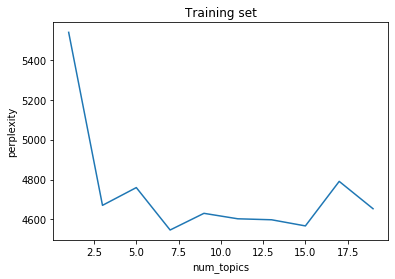

In [59]:
plt.plot(num_topics, perplexities)
plt.title('Training set')
plt.ylabel('perplexity')
plt.xlabel('num_topics')

In [60]:
perplexities = []
for idx, model in enumerate(models):
    topic_mat = model.transform(bow_val)
    perplexity = model.perplexity(bow_val)
    print('model no.: {}, document-topic matrix shape: {}'\
          ' perplexity: {}'.format(idx+1, topic_mat.shape, perplexity))
    perplexities.append(perplexity)

model no.: 1, document-topic matrix shape: (2652, 1) perplexity: 5563.332580685503
model no.: 2, document-topic matrix shape: (2652, 3) perplexity: 5358.993137949157
model no.: 3, document-topic matrix shape: (2652, 5) perplexity: 6131.207397630618
model no.: 4, document-topic matrix shape: (2652, 7) perplexity: 6146.6909130042095
model no.: 5, document-topic matrix shape: (2652, 9) perplexity: 6643.231216745761
model no.: 6, document-topic matrix shape: (2652, 11) perplexity: 6937.44835435107
model no.: 7, document-topic matrix shape: (2652, 13) perplexity: 7356.578781160066
model no.: 8, document-topic matrix shape: (2652, 15) perplexity: 7513.896690481526
model no.: 9, document-topic matrix shape: (2652, 17) perplexity: 8445.706809667854
model no.: 10, document-topic matrix shape: (2652, 19) perplexity: 8682.300168248064


Text(0.5, 0, 'num_topics')

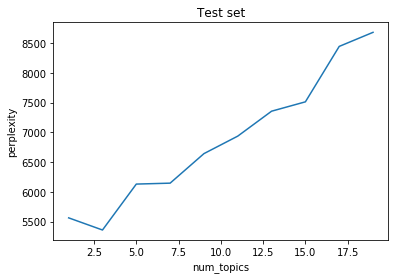

In [61]:
plt.plot(num_topics, perplexities)
plt.title('Test set')
plt.ylabel('perplexity')
plt.xlabel('num_topics')

Surprisingly, the perplexity of our test set increases with the number of topics. This is not the case generically where we expect the perplexity to decrease as the number of topics increases. This perhaps because our corpora is relatively small leading to a high degree of over-fitting, such that overfitting increases as the number of topics is increased. This is something that has been noticed by other people too for e.g. see [here](https://github.com/RaRe-Technologies/gensim/issues/701). This has also been noticed in  [this](https://stats.stackexchange.com/questions/364494/lda-and-test-data-perplexity) stackexchange post where someone suggested that scikit-learns algo. for computing perplexity has a bug. I don't think that is the case and strongly believe that this is simple due to overfitting.

To confirm our hypothesis of LDA overfitting on a small dataset, let us consider all the documents in 20newsgroups dataseta and fit and LDA to them. 

In [62]:
newsgroups_train = fetch_20newsgroups(subset = 'train', remove = remove)
newsgroups_test = fetch_20newsgroups(subset = 'test', remove = remove)

In [67]:
print('num document in training set: {}'.format(newsgroups_train.filenames.shape))
print('num document in validation set: {}'.format(newsgroups_test.filenames.shape))

num document in training set: (11314,)
num document in validation set: (7532,)


In [66]:
bow = vectorizer.fit_transform(newsgroups_train.data)
bow.shape

(11314, 69712)

In [69]:
bow_val = vectorizer.transform(newsgroups_test.data)
bow_val.shape

(7532, 69712)

In [70]:
num_topics = range(5, 35, 5)
models = []
train_perplexities = []
for num in num_topics:
    LDA = LatentDirichletAllocation(n_components = num)
    LDA.fit(bow)
    models.append(LDA)
    train_perplexities.append(LDA.bound_)

Text(0.5, 0, 'num_topics')

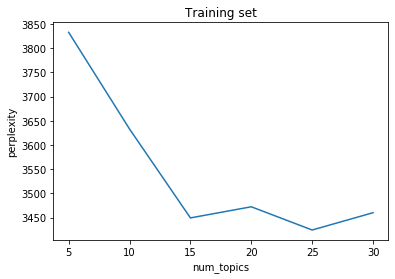

In [71]:
plt.plot(num_topics, train_perplexities)
plt.title('Training set')
plt.ylabel('perplexity')
plt.xlabel('num_topics')

In [72]:
val_perplexities = []
for model in models:
    perpl = model.perplexity(bow_val)
    val_perplexities.append(perpl)

Text(0.5, 0, 'num_topics')

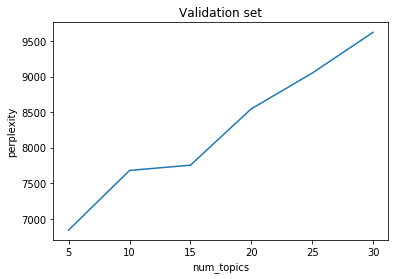

In [73]:
plt.plot(num_topics, val_perplexities)
plt.title('Validation set')
plt.ylabel('perplexity')
plt.xlabel('num_topics')

This is weird! The full 20newsgroups dataset is reasonably large (the training set contains ~ 11k documents and ~69k different words) yet the validation set perplexity increases with num_topics. :(

#### LDA with tf-idf (not a good thing to do)

Let's check this with a Tf-Idf vectorizer. Note that we don't really expect this to really work. The reason is the LDA assumes a bow input i.e. it is based on term counts of each document. For e.g. see the dicussion [here](https://www.quora.com/How-do-you-combine-LDA-and-tf-idf). Nonetheless, we are going to try just for the sake of it. 

In [76]:
regex = r'[a-z]{2,}'
vectorizer = TfidfVectorizer(stop_words = stop_words, preprocessor = preproc, 
                             token_pattern = regex)
bow = vectorizer.fit_transform(newsgroups_train.data)
bow.shape

/home/prarit/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(11314, 69712)

In [77]:
bow_val = vectorizer.transform(newsgroups_test.data)
bow_val.shape

(7532, 69712)

In [78]:
num_topics = range(5, 35, 5)
models = []
train_perplexities = []
val_perplexities = []
for num in num_topics:
    LDA = LatentDirichletAllocation(n_components = num)
    LDA.fit(bow)
    models.append(LDA)
    train_perplexities.append(LDA.bound_)
    val_perp = LDA.perplexity(bow_val)
    val_perplexities.append(val_perp)

Text(0.5, 0, 'num_topics')

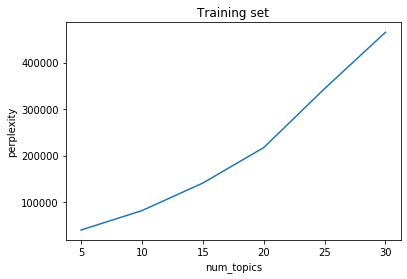

In [79]:
plt.plot(num_topics, train_perplexities)
plt.title('Training set')
plt.ylabel('perplexity')
plt.xlabel('num_topics')

Text(0.5, 0, 'num_topics')

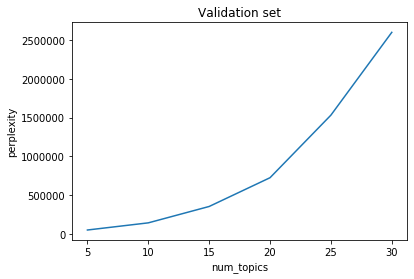

In [80]:
plt.plot(num_topics, val_perplexities)
plt.title('Validation set')
plt.ylabel('perplexity')
plt.xlabel('num_topics')

The perplexities incease extremely sharply in both the training and the validation set. This is in accord with our expectation that apply tf-idf with LDA is not a correct approach. 

### Topic Coherence

Another measure for goodness of a topic model is ```topic coherence``` which basically measures the semantic similarity of the words that contribure most to a topic. Topics with a high ```topic coherence``` can therefore be expected to be more human interpretable. Unfortunately, sklearn does not implement ```topic coherence``` as one of its measure. It is however provided in ```gensim```. For more details on ```topic coherence```, [this](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0) is an excellent blog. On the otherhand [this](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) blog goes over the details of how to use gensim for topic modeling.